In this notebook, we will present how to merge datasets in scVI

In [1]:
import os
os.chdir("/home/ec2-user/scVI/")
os.getcwd()

'/home/ec2-user/scVI'

In [2]:
use_cuda = True

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.dataset.pbmc import Dataset10X, PbmcDataset

from scvi.inference.posterior import *
from scvi.metrics.clustering import select_indices_evenly, clustering_scores, entropy_batch_mixing
from scipy import sparse
from scvi.models.vae import VAE
from scvi.inference import UnsupervisedTrainer

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scvi.harmonization.utils_chenling import get_matrix_from_dir,assign_label,run_model
import pandas as pd
from sklearn.preprocessing import scale

In [5]:
count, geneid, cellid = get_matrix_from_dir('cite')
count = count.T.tocsr()
seurat = np.genfromtxt('../cite/cite.seurat.labels', dtype='str', delimiter=',')
cellid = np.asarray([x.split('-')[0] for x in cellid])
labels_map = [0, 0, 1, 2, 3, 4, 5, 6]
labels = seurat[1:, 4]
cell_type = ["CD4 T cells", "NK cells", "CD14+ Monocytes", "B cells", "CD8 T cells", "FCGR3A Monocyte", "na"]
cite = assign_label(cellid, geneid, labels_map, count, cell_type, seurat)

In [87]:
adt_expression_clr = pd.read_csv('../cite/ADT_cut_clr.csv')
dat = [adt_expression_clr.loc[adt_expression_clr['cellid'] == x] for x in seurat[1:,5]]
protein = pd.concat(dat)

array(['CD4 T cells', 'NK cells', 'CD14+ Monocytes', 'B cells',
       'CD8 T cells', 'FCGR3A Monocyte', 'na'], dtype='<U15')

In [7]:
cell_types = np.array(["cd4_t_helper", "regulatory_t", "naive_t", "memory_t", "cytotoxic_t", "naive_cytotoxic",
                       "b_cells", "cd34", "cd56_nk", "cd14_monocytes"])
cell_type_name = np.array(["CD4 T cells 2", "CD4 T cells Regulatory", "CD4 T cells Naive", "CD4 Memory T cells", "CD8 T cells", "CD8 T cells Naive",
                       "B cells", "CD34 cells", "NK cells", "CD14+ Monocytes"])

datasets = []
for i,cell_type in enumerate(cell_types):
    dataset = Dataset10X(cell_type, save_path='data/')
    dataset.cell_types = np.array([cell_type_name[i]])
    dataset.labels = dataset.labels.astype('int')
    dataset.subsample_genes(dataset.nb_genes)
    dataset.gene_names = dataset.gene_symbols
    datasets += [dataset]

pure = GeneExpressionDataset.concat_datasets(*datasets, shared_batches=True)


File data/10X/cd4_t_helper/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16049 genes
Downsampling from 11213 to 11213 cells
File data/10X/regulatory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15950 genes
Downsampling from 10263 to 10263 cells
File data/10X/naive_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 15565 genes
Downsampling from 10479 to 10479 cells
File data/10X/memory_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16169 genes
Downsampling from 10224 to 10224 cells
File data/10X/cytotoxic_t/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 32738 to 16130 genes

In [8]:
pure.cell_types[pure.cell_types=='CD4 T cells'] = 'CD4 T cell'

In [9]:
donor = Dataset10X('fresh_68k_pbmc_donor_a')
donor.gene_names = donor.gene_symbols

File data/10X/fresh_68k_pbmc_donor_a/filtered_gene_bc_matrices.tar.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [10]:
import os
if not os.path.isfile('data/10X/fresh_68k_pbmc_donor_a/68k_pbmc_barcodes_annotation.tsv'):
    import urllib.request
    annotation_url = 'https://raw.githubusercontent.com/10XGenomics/single-cell-3prime-paper/master/pbmc68k_analysis/68k_pbmc_barcodes_annotation.tsv'
    urllib.request.urlretrieve(annotation_url, 'data/10X/fresh_68k_pbmc_donor_a/68k_pbmc_barcodes_annotation.tsv')  

annotation = pd.read_csv('data/10X/fresh_68k_pbmc_donor_a/68k_pbmc_barcodes_annotation.tsv',sep='\t')
cellid1 = donor.barcodes
temp = cellid1.join(annotation)
assert all(temp[0]==temp['barcodes'])

donor.cell_types,donor.labels = np.unique(temp['celltype'],return_inverse=True)

In [11]:
print(pure.cell_types)
print(donor.cell_types)
donor.labels = donor.labels.reshape(len(donor.labels),1)
donor.cell_types = np.array([ 'CD14+ Monocytes','B cells','CD34 cells', 'CD4 T cells','CD4 T cells Regulatory', 
                             'CD4 T cells Naive','CD4 Memory T cells','NK cells',
                            'CD8 T cells',  'CD8 T cells Naive', 'Dendritic'])

['CD4 T cells Regulatory' 'CD8 T cells Naive' 'B cells' 'CD14+ Monocytes'
 'CD4 T cells Naive' 'CD4 T cells 2' 'CD34 cells' 'NK cells'
 'CD4 Memory T cells' 'CD8 T cells']
['CD14+ Monocyte' 'CD19+ B' 'CD34+' 'CD4+ T Helper2' 'CD4+/CD25 T Reg'
 'CD4+/CD45RA+/CD25- Naive T' 'CD4+/CD45RO+ Memory' 'CD56+ NK'
 'CD8+ Cytotoxic T' 'CD8+/CD45RA+ Naive Cytotoxic' 'Dendritic']


In [12]:
gene_dataset = GeneExpressionDataset.concat_datasets(cite,donor, pure)

Keeping 11300 genes


In [13]:
gene_dataset.X.shape

(169850, 11300)

In [14]:
gene_dataset.cell_types

array(['CD4 T cells Regulatory', 'FCGR3A Monocyte', 'CD8 T cells Naive',
       'B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD4 T cells Naive',
       'Dendritic', 'CD4 T cells 2', 'CD34 cells', 'na', 'NK cells',
       'CD4 Memory T cells', 'CD8 T cells'], dtype='<U22')

In [15]:
# plotname='CiteDonorPure'
# latent, batch_indices, labels, keys, stats = run_model(
#     'writedata', gene_dataset, 0, 0,filename=plotname)

In [15]:
def subsetByGenenames(dataset, subsetnames):
    genenames = dataset.gene_names
    filter = np.asarray([x in subsetnames for x in genenames])
    dataset.X = dataset.X[:, filter]
    dataset.update_genes(np.arange(len(filter))[filter])
    return dataset

def SubsetGenes(dataset1,dataset2,dataset3,gene_dataset,plotname,ngenes=1000):
    import pandas as pd
    genes1 = pd.read_table('../Seurat_data/' + plotname + '.1.hvg_info.csv', delimiter=',')
    geneid1 = np.asarray([x.replace('gene_', '') for x in genes1[genes1.keys()[0]]]).astype('int')
    genenames1 = genes1['genename']
    genes2 = pd.read_table('../Seurat_data/' + plotname + '.2.hvg_info.csv', delimiter=',')
    geneid2 = np.asarray([x.replace('gene_', '') for x in genes2[genes2.keys()[0]]]).astype('int')
    genenames2 = genes2['genename']
    genes3 = pd.read_table('../Seurat_data/' + plotname + '.3.hvg_info.csv', delimiter=',')
    geneid3 = np.asarray([x.replace('gene_', '') for x in genes3[genes3.keys()[0]]]).astype('int')
    genenames3 = genes3['genename']
    assert np.sum(np.asarray(genenames1) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
    assert np.sum(np.asarray(genenames2) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
    assert np.sum(np.asarray(genenames3) == gene_dataset.gene_names) == len(gene_dataset.gene_names)
    geneid = np.union1d(np.union1d(geneid1[:ngenes], geneid2[:ngenes]),geneid3[:ngenes]) - 1
    genes = gene_dataset.gene_names[geneid]
    dataset1 = subsetByGenenames(dataset1,genes)
    dataset2 = subsetByGenenames(dataset2,genes)
    dataset3 = subsetByGenenames(dataset2,genes)
    gene_dataset = subsetByGenenames(gene_dataset,genes)
    return dataset1,dataset2,dataset3,gene_dataset


In [16]:
cite,donor,pure,gene_dataset = SubsetGenes(cite,donor,pure,gene_dataset,'CiteDonorPure')

Downsampling from 17014 to 2071 genes
Downsampling from 6616 to 6616 cells
Downsampling from 32738 to 2071 genes
Downsampling from 68579 to 68579 cells
Downsampling from 2071 to 2071 genes
Downsampling from 68579 to 68579 cells
Downsampling from 11300 to 2071 genes
Downsampling from 169850 to 169850 cells


In [17]:
vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches, n_labels=gene_dataset.n_labels,
          n_hidden=128, n_latent=10, n_layers=2, dispersion='gene')
trainer = UnsupervisedTrainer(vae, gene_dataset, train_size=1.0)
# trainer.train(n_epochs=100)
import torch
# torch.save(trainer.model,'../models/CiteDonorPure.vae.pkl')
trainer.model = torch.load('../models/CiteDonorPure.vae.pkl')

In [18]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
# latent, idx_t_sne = trainer.train_set.apply_t_sne(latent, 10000)

In [19]:
batch_indices = batch_indices.ravel()
np.unique(batch_indices)

array([0, 1, 2])

In [20]:
from scvi.metrics.clustering import select_indices_evenly
from sklearn.manifold import TSNE
import seaborn as sns

citeidx = np.arange(len(batch_indices))[batch_indices==0]
sample = np.unique(np.concatenate([select_indices_evenly(2000, labels),np.arange(len(batch_indices))[batch_indices==0]]))

In [21]:
colors = sns.color_palette('tab20')
latent_s = latent[sample, :]
label_s = labels[sample]
batch_s = batch_indices[sample]


In [22]:
if latent_s.shape[1] != 2:
    latent_s = TSNE().fit_transform(latent_s)

In [23]:
latent_s.shape

(28098, 2)

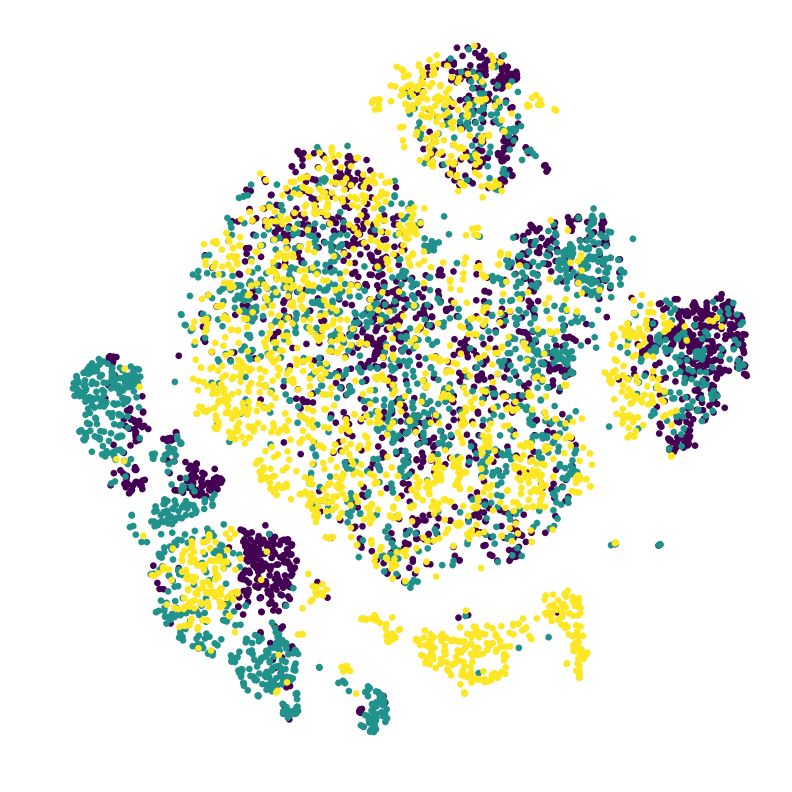

In [25]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
batch_s = batch_s.ravel()
temp = select_indices_evenly(2000, batch_s)

plt.scatter(latent_s[temp, 0], latent_s[temp, 1], c=batch_s[temp], edgecolors='none')
plt.axis("off")
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.


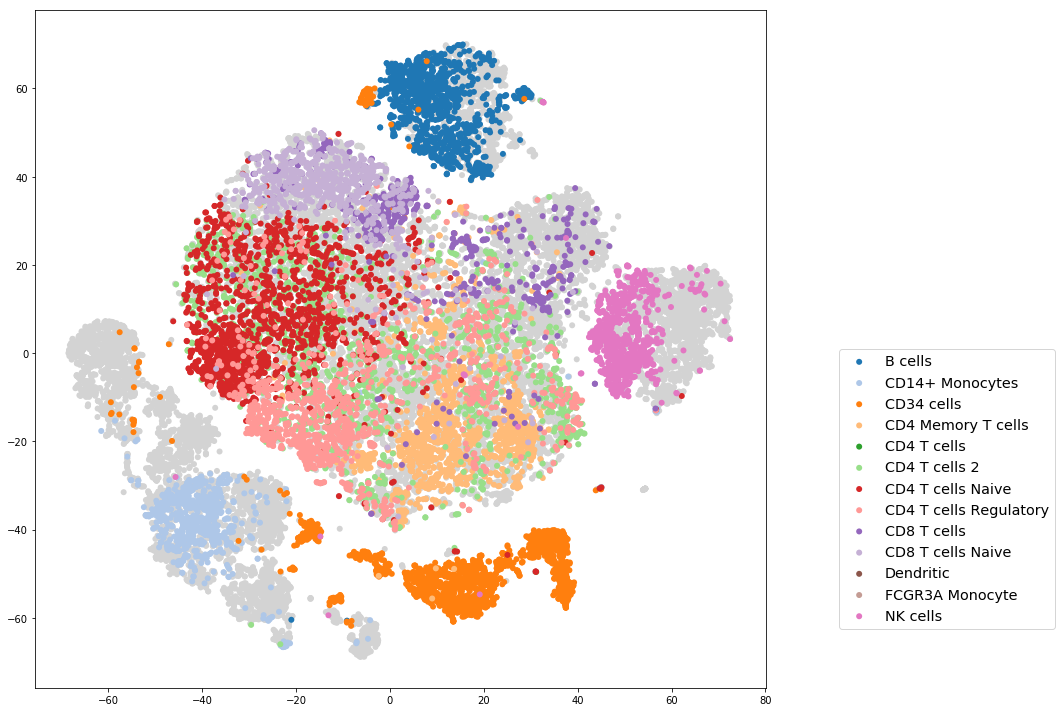

In [29]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(latent_s[batch_s!=2, 0], latent_s[batch_s!=2, 1], c='lightgrey',
        edgecolors='none')
ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
for i,k in enumerate(key_order):
    if keys[k]!='unlabelled' and keys[k]!='na':
        idx = (label_s==k).astype('int') * (batch_s==2).astype('int') ==1 
        ax.scatter(latent_s[idx, 0], latent_s[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
        ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
fig.tight_layout()


No handles with labels found to put in legend.


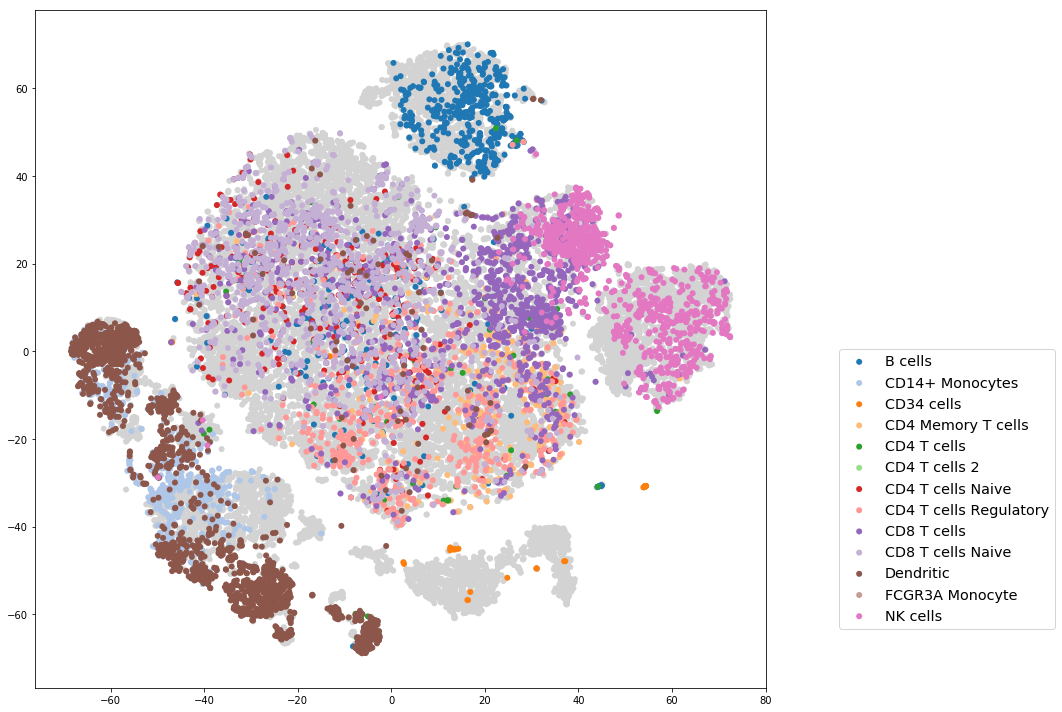

In [30]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(latent_s[batch_s!=1, 0], latent_s[batch_s!=1, 1], c='lightgrey',
        edgecolors='none')
ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
for i,k in enumerate(key_order):
    if keys[k]!='unlabelled' and keys[k]!='na':
        idx = (label_s==k).astype('int') * (batch_s==1).astype('int') ==1 
        ax.scatter(latent_s[idx, 0], latent_s[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
        ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
fig.tight_layout()


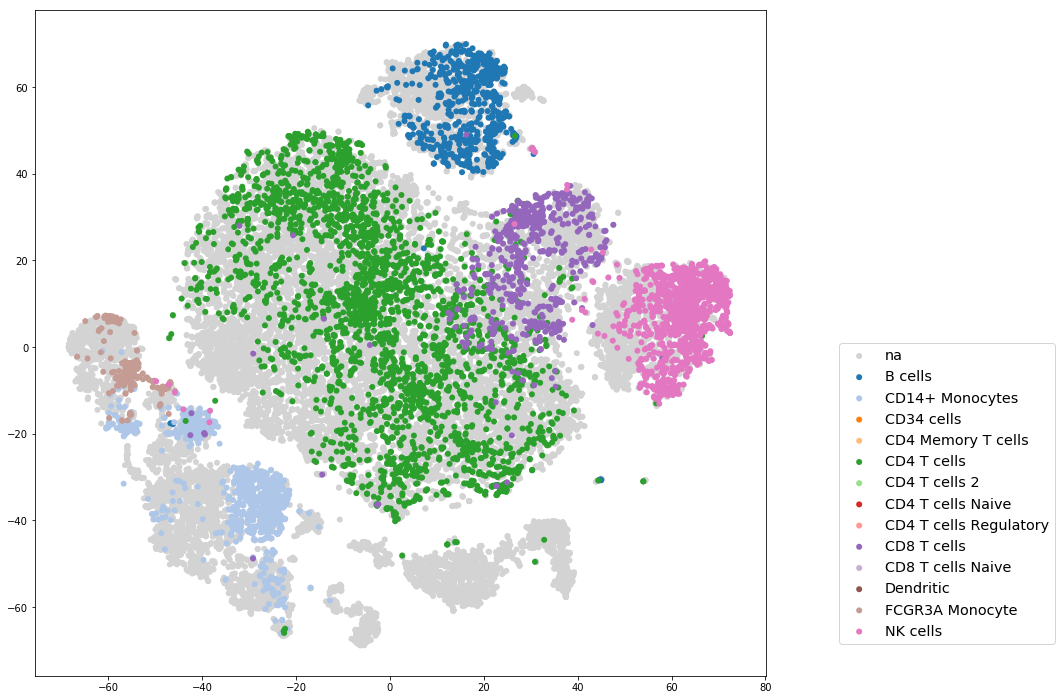

In [31]:
keys = gene_dataset.cell_types
key_order = np.argsort(keys)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(latent_s[batch_s!=0, 0], latent_s[batch_s!=0, 1], c='lightgrey', label=keys[k],
        edgecolors='none')
ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
for i,k in enumerate(key_order):
    if keys[k]!='unlabelled' and keys[k]!='na':
        idx = (label_s==k).astype('int') * (batch_s==0).astype('int') ==1 
        ax.scatter(latent_s[idx, 0], latent_s[idx, 1], c=colors[i%20], label=keys[k],
                   edgecolors='none')
        ax.legend(bbox_to_anchor=(1.1, 0.5), borderaxespad=0, fontsize='x-large')
fig.tight_layout()


In [32]:
protein.columns.values

array(['cellid', 'CD3', 'CD4', 'CD8', 'CD2', 'CD45RA', 'CD57', 'CD16',
       'CD14', 'CD11c', 'CD19'], dtype=object)

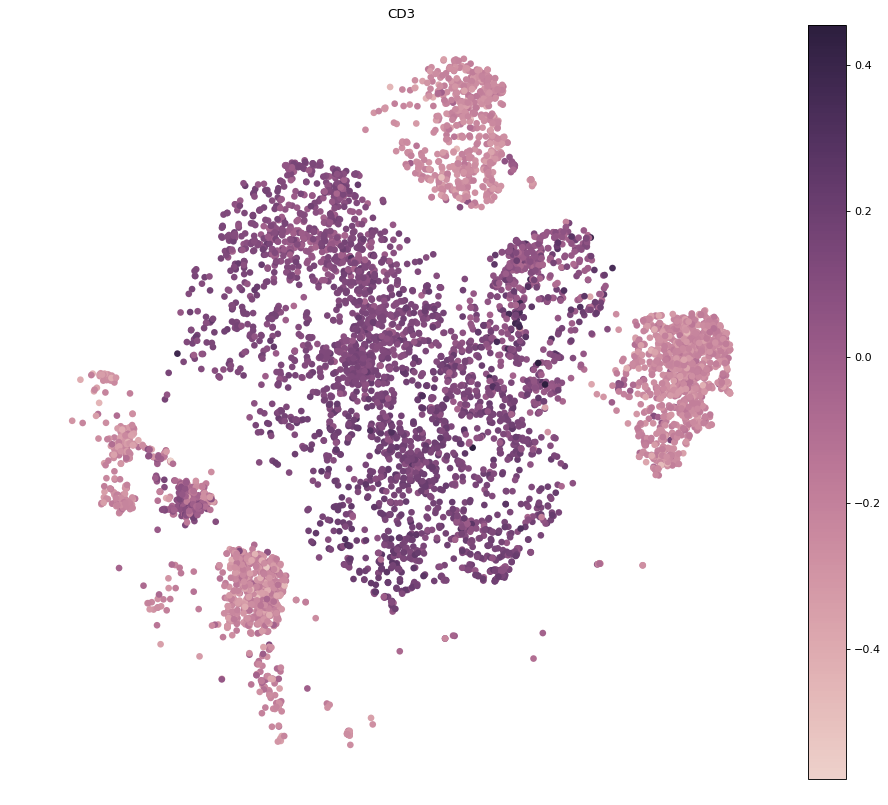

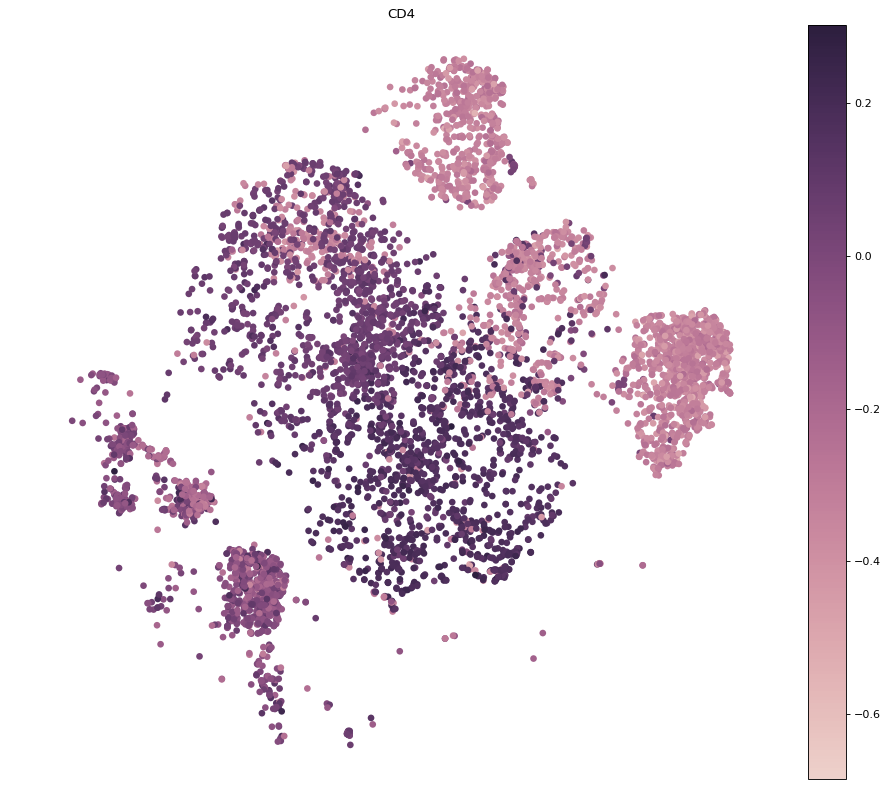

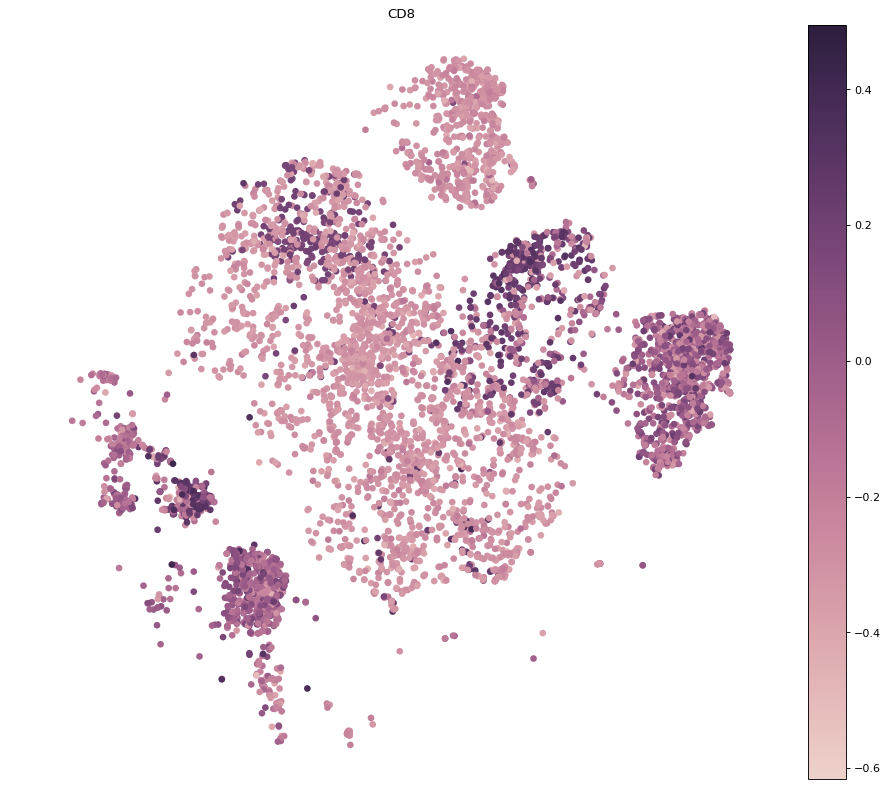

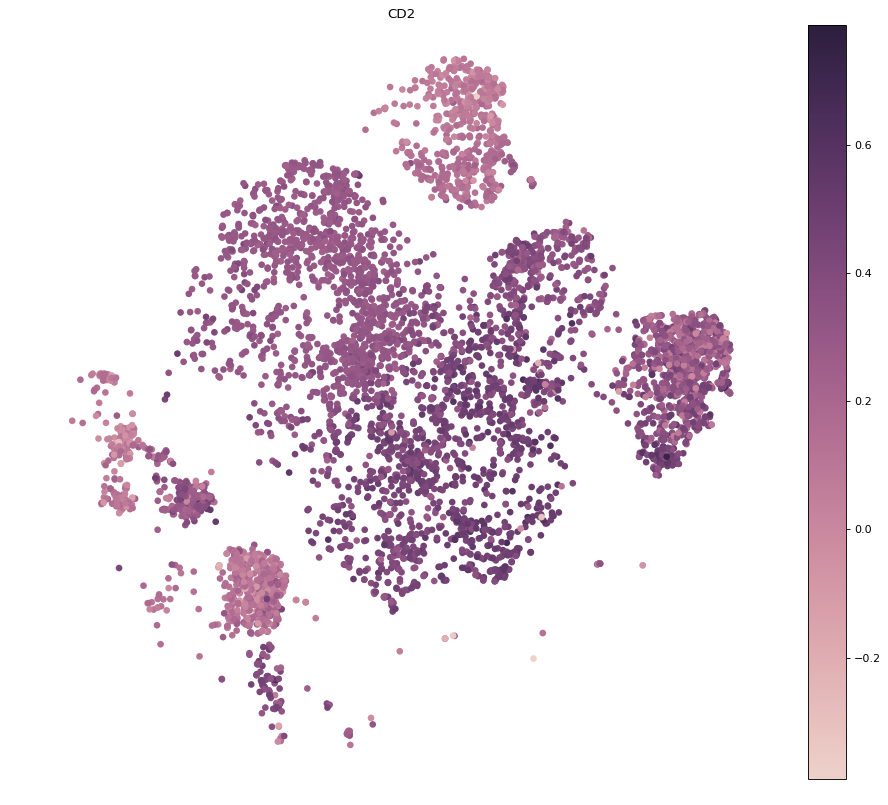

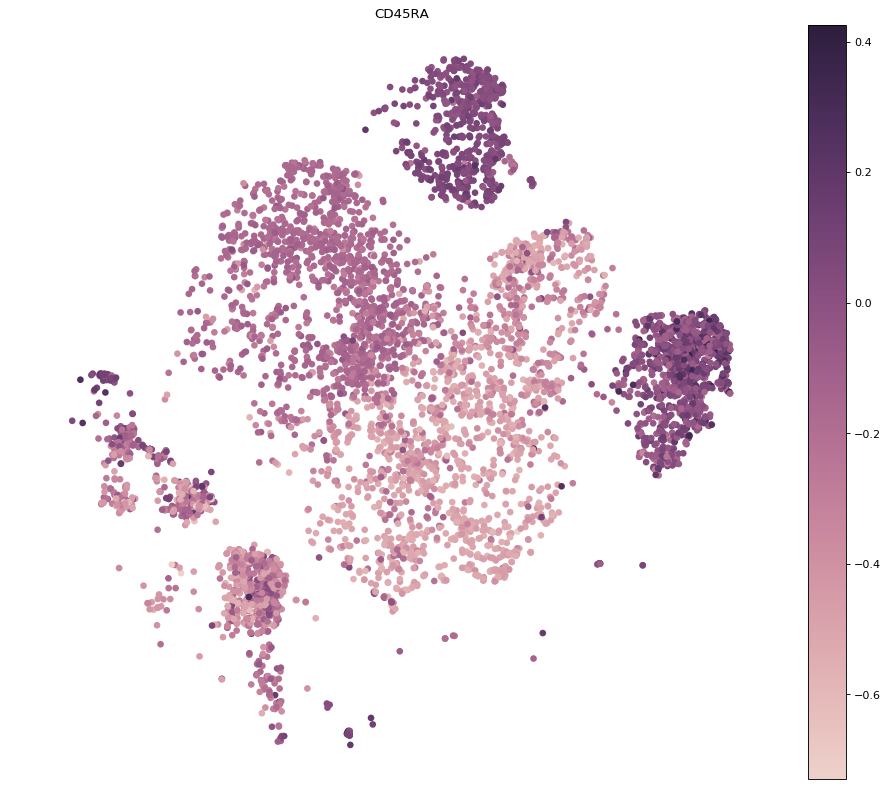

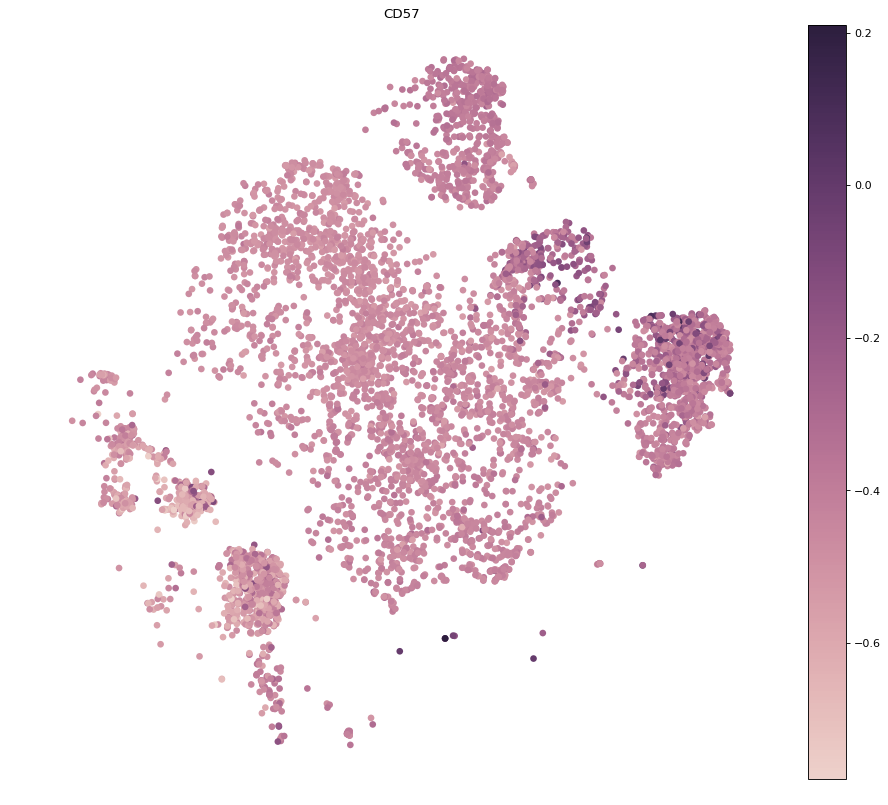

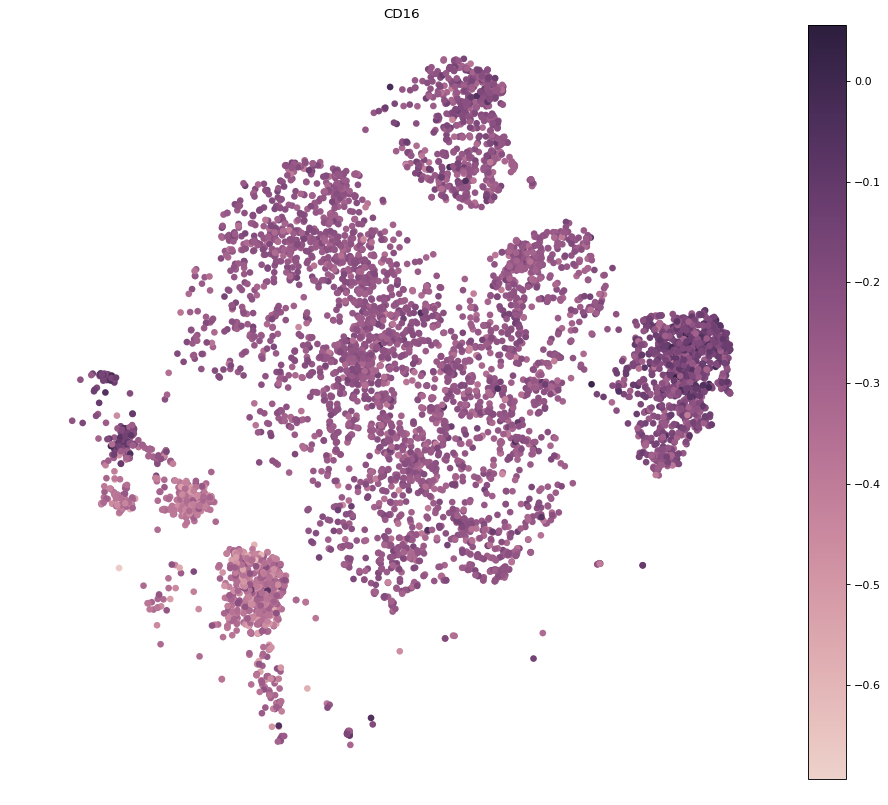

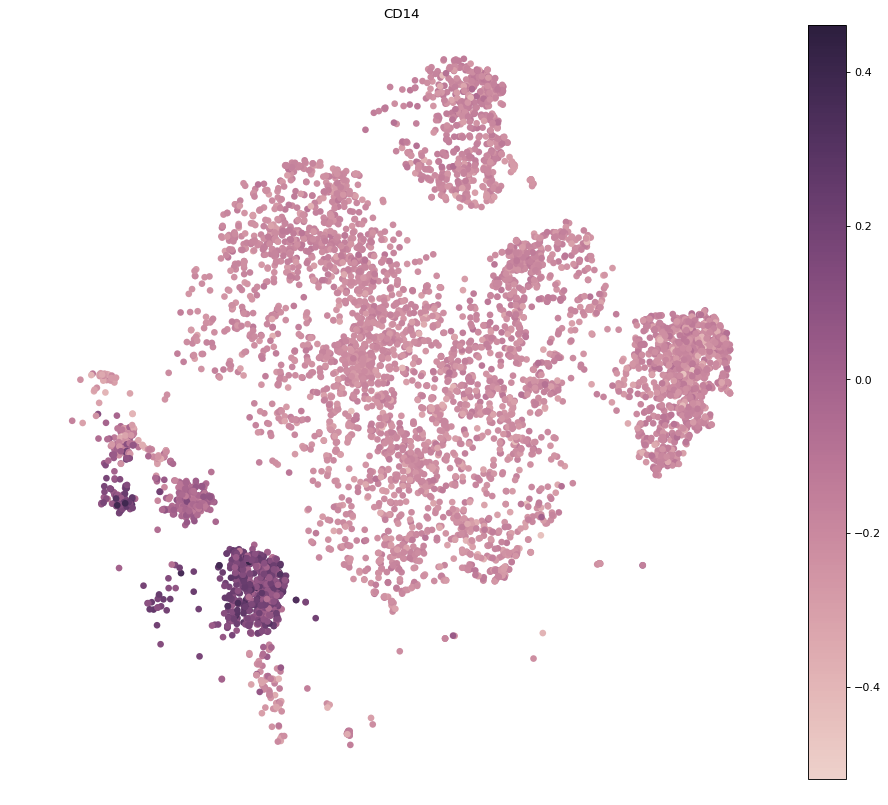

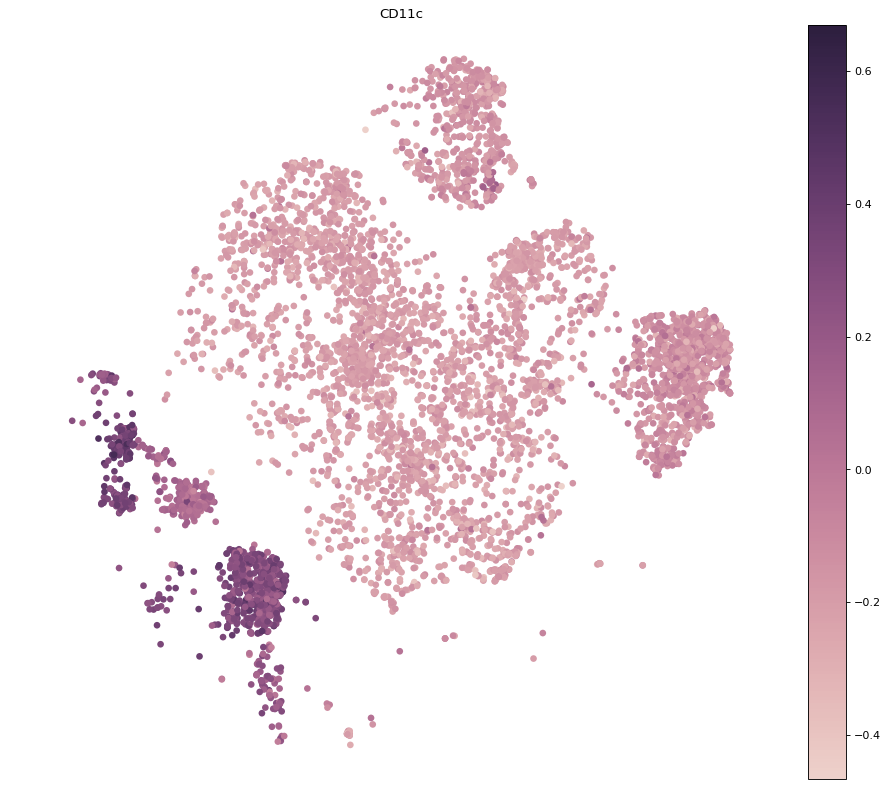

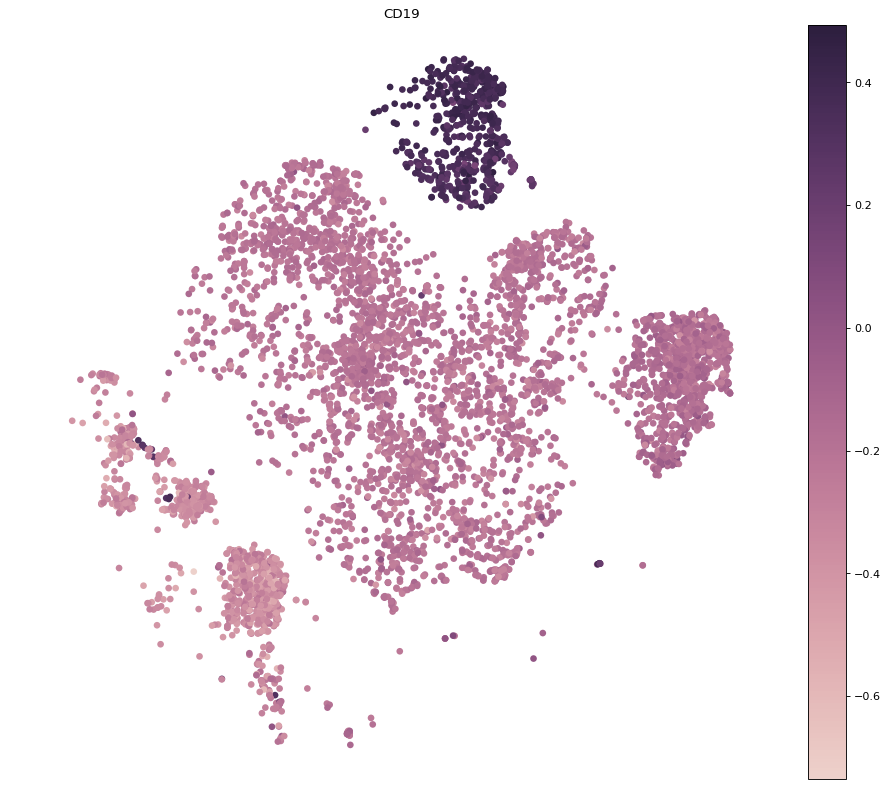

In [33]:
for marker in protein.columns.values[1:]:
    fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
    batch_s = batch_s.ravel()
    sample = select_indices_evenly(2000, batch_s)
    plt.scatter(latent_s[np.arange(len(cite)), 0], latent_s[np.arange(len(cite)), 1], 
                c=np.asarray(protein[marker]), cmap = sns.cubehelix_palette(as_cmap=True),edgecolors='none')
    plt.axis("off")
    plt.colorbar()
    plt.tight_layout()
    plt.title(marker)
    plt.show()

In [124]:
from sklearn.neighbors import NearestNeighbors
# 10 nearest neighbor in citeseq from each cell in pure population
nbrs = NearestNeighbors(n_neighbors=3 + 1).fit(laten_scanvi[batch_indices==0,:])
indices = nbrs.kneighbors(laten_scanvi[batch_indices==2,:], return_distance=False)[:, 1:]

In [125]:
j=0
idx = indices[labels[batch_indices==2] == j]

In [126]:
adt_expression_clr = pd.read_csv('../cite/ADT_cut_clr.csv')
dat = [adt_expression_clr.loc[adt_expression_clr['cellid'] == x] for x in seurat[1:,5]]
protein = pd.concat(dat)
markers = ["CD3","CD4","CD8","CD2","CD45RA","CD57","CD16","CD14","CD11c","CD19"]
adt_expression_clr = [np.asarray(protein[marker]) for marker in markers]

In [127]:
adt_expression_clr = np.asarray(adt_expression_clr)

In [128]:
adt_expression_clr = adt_expression_clr.T
adt_expression_clr[adt_expression_clr<0]=0
from sklearn.preprocessing import scale
adt_expression_clr = scale(adt_expression_clr,with_mean=False)

In [129]:
celltypes2 = keys[np.unique(labels[batch_indices==2])]
celltype_order = np.argsort(celltypes2)


In [130]:

protein=[]
for j in np.unique(labels[batch_indices==2])[celltype_order]:
    idx = indices[labels[batch_indices==2] == j]
    clr = adt_expression_clr[idx.ravel()]
    protein.append(np.mean(clr,axis=0))

protein = np.asarray(protein)


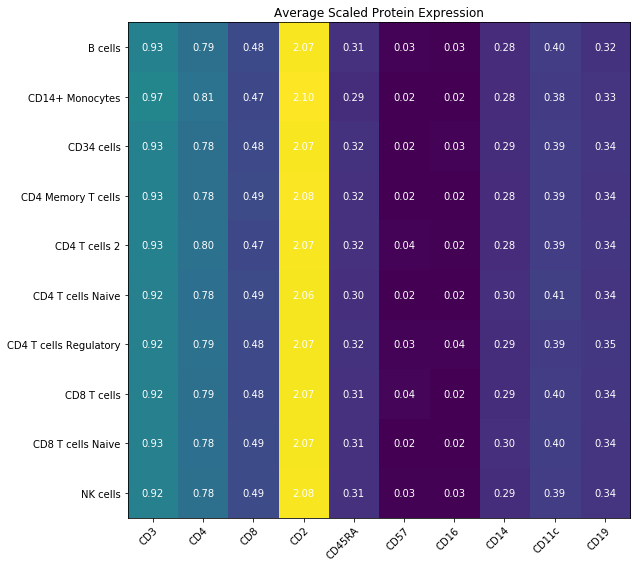

In [131]:

def Heatmap(matrix, rownames,colnames,title):
    fig, ax = plt.subplots(figsize=(9,8))
    # We want to show all ticks...
    im = ax.imshow(matrix,aspect='auto')
    ax.set_xticks(np.arange(len(rownames)))
    ax.set_yticks(np.arange(len(colnames)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(rownames)
    ax.set_yticklabels(colnames)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(len(colnames)):
        for j in range(len(rownames)):
            text = ax.text(j, i, "{:.2f}".format(matrix[i, j]),
                           ha="center", va="center", color="w")
    ax.set_title(title)
    fig.tight_layout()
    plt.savefig('../heatmap.png')


Heatmap(protein,markers, celltypes2[celltype_order],'Average Scaled Protein Expression')


In [134]:
np.sum(batch_indices==0)

6616

In [123]:
from scvi.models.scanvi import SCANVI
from scvi.inference import SemiSupervisedTrainer

scanvi = SCANVI(gene_dataset.nb_genes, gene_dataset.n_batches, gene_dataset.n_labels, n_layers=2)
scanvi.load_state_dict(vae.state_dict(), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, gene_dataset, classification_ratio=1,
                                       n_epochs_classifier=1, lr_classification=5 * 1e-3)

trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=(gene_dataset.batch_indices == 2))
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(
    indices=(gene_dataset.batch_indices != 2)
)
# trainer_scanvi.train(n_epochs=50)
# torch.save(trainer_scanvi.model,'../models/CiteDonorPure.scanvi.pkl')
trainer.model = torch.load('../models/CiteDonorPure.vae.pkl')
scanvi_posterior = trainer_scanvi.create_posterior(trainer_scanvi.model,gene_dataset,indices=np.arange(len(gene_dataset)))
laten_scanvi, _, _ = scanvi_posterior.sequential().get_latent()
